In [1]:
import tensorflow as tf
# tf.enable_eager_execution()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from glob import glob
import pickle
from tensorflow.keras import layers, Sequential, datasets, models, losses, Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import datetime
import sys
from tensorflow.keras.backend import clear_session
from trainingfuncs import *
from math_utils import *
from utils import *
from scipy.spatial import distance
import seaborn as sns
import umap

In [2]:
sys.path.append("..") # Adds higher directory to python modules path.
from helpers.dataset_vars import *
from helpers.myclasses import *

In [3]:
morph_folder = os.path.abspath('/mnt/cube/kai/repositories/morphs/data/stimuli')

results_folder = os.path.abspath('/mnt/cube/kai/results/perceptual_loss/morph')

# load all dfs

In [4]:
finetune_pred = pickle.load(open(os.path.join(results_folder, 'norm_robust', 'all_predicted.p'), 'rb'))
pretrain_pred = pickle.load(open(os.path.join(results_folder, 'pretrained', 'pretrained_predicted.p'), 'rb'))
group1_behav = pickle.load(open(os.path.join(results_folder, 'group1_behav.p'), 'rb'))
group2_behav = pickle.load(open(os.path.join(results_folder, 'group2_behav.p'), 'rb'))
group3_behav = pickle.load(open(os.path.join(results_folder, 'group3_behav.p'), 'rb'))

In [14]:
all_groups = pd.concat([finetune_pred, pretrain_pred,
                       group1_behav, group2_behav, group3_behav]).reset_index(drop=True)

In [15]:
all_groups

,index,min_val,max_val,slope,inflection,group,metric,subj
0,ae,1.000000e-16,1.000000,0.033214,75.202742,Group 1,rmse,NaN
1,af,1.000000e-16,0.945304,0.032496,84.500302,Group 1,rmse,NaN
2,ag,1.000000e-16,0.860692,0.037051,76.503340,Group 1,rmse,NaN
3,ah,1.000000e-16,0.616709,0.065078,56.980419,Group 1,rmse,NaN
4,be,7.801580e-03,0.904488,0.054682,84.002627,Group 1,rmse,NaN
...,...,...,...,...,...,...,...,...
333,df,1.822476e-02,0.951094,0.202028,48.683433,Group 3,behav,B1101
334,fg,8.661837e-02,0.913664,1.151891,78.842110,Group 3,behav,B1222
335,fg,4.770582e-02,0.976152,0.275545,76.420456,Group 3,behav,B1101
336,fh,6.630351e-02,0.916032,0.231404,67.285280,Group 3,behav,B1222


In [16]:
all_groups= all_groups.drop(all_groups[all_groups.metric=='frmse'].index).reset_index(drop=True)

In [17]:
all_groups.group.unique()

array(['Group 1', 'Group 2', 'Group 3', nan], dtype=object)

In [18]:
all_groups.metric.unique()

array(['rmse', 'fcosine', 'behav'], dtype=object)

In [19]:
def get_formal_metric(x):
    if x['metric'] == 'rmse':
        return 'MSE'
    elif x['metric'] == 'behav':
        return 'Ground Truth'
    else:
        if x['group'] == 'Pre-train':
            return 'Pre-train'
        else:
            return 'APD'

In [20]:
def get_training_condition(x):
    if x['metric'] == 'rmse':
        return 'MSE'
    elif x['metric'] == 'behav':
        return 'Ground Truth'
    else:
        if x['group'] == 'Pre-train':
            return 'Pre-train'
        else:
            return 'Fine-tune'

In [21]:
all_groups.group.fillna('Pre-train', inplace=True)

In [24]:
all_groups['condition'] = all_groups.apply(get_training_condition, axis=1)

In [25]:
all_groups['metric_formal'] = all_groups.apply(get_formal_metric, axis=1)

In [26]:
all_groups.subj.fillna(all_groups.metric_formal, inplace=True)

# MSE vs APD vs Ground Truth

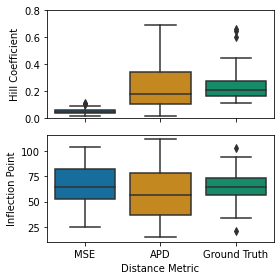

In [66]:
fig, ax = plt.subplots(2, 1, figsize=(4, 4), sharex=True)
for i, metric in enumerate(['slope', 'inflection']):
    sns.boxplot(y=metric, x='metric_formal',data=all_groups[all_groups.metric_formal.isin(['MSE', 'APD', 'Ground Truth'])],
                    order = ['MSE', 'APD', 'Ground Truth'], ax=ax[i])
    if metric=='slope':
        ax[i].set_ylim([0,0.8])
        ax[i].set_ylabel('Hill Coefficient')
    else:
        ax[i].set_ylabel('Inflection Point')
ax[0].set_xlabel('')
ax[1].set_xlabel('Distance Metric')
plt.tight_layout()

(0.0, 1.0)

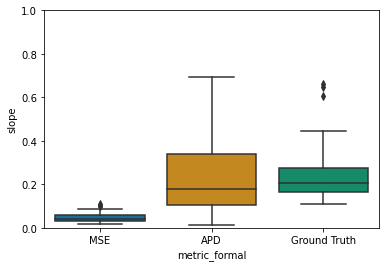

In [34]:
ax = sns.boxplot(y='slope', x='metric_formal',data=all_groups[all_groups.metric_formal.isin(['MSE', 'APD', 'Ground Truth'])],
                order = ['MSE', 'APD', 'Ground Truth'])
ax.set_ylim([0,1])

In [28]:
all_groups['stim'] = all_groups['index']
all_groups = all_groups.drop(columns=['index'])

In [29]:
import statsmodels.formula.api as smf

In [30]:
all_groups.metric_formal.unique()

array(['MSE', 'APD', 'Pre-train', 'Ground Truth'], dtype=object)

In [38]:
model = smf.mixedlm("slope ~ C(metric_formal, Treatment('Ground Truth')) ",
                    all_groups[all_groups.metric_formal.isin(['MSE', 'APD', 'Ground Truth'])],
                    groups= "group").fit()

model.summary()

/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Mixed Linear Model Regression Results
=============================================================================================
Model:                          MixedLM              Dependent Variable:              slope  
No. Observations:               245                  Method:                          REML   
No. Groups:                     4                    Scale:                           0.0265 
Min. group size:                23                   Log-Likelihood:                  89.3325
Max. group size:                96                   Converged:                       Yes    
Mean group size:                61.2                                                         
---------------------------------------------------------------------------------------------
                                                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------------------
Intercept                                           0.238    0.014 16.503 0.000  0.210  0.266
C(metric_formal, Treatment('Ground Truth'))[T.APD]  0.045    0.028  1.616 0.106 -0.010  0.100
C(metric_formal, Treatment('Ground Truth'))[T.MSE] -0.192    0.024 -7.913 0.000 -0.239 -0.144
group Var                                           0.000    0.003                           
=============================================================================================

"""

In [39]:
model = smf.mixedlm("slope ~ C(metric_formal, Treatment('Ground Truth')) ",
                    all_groups[all_groups.metric_formal.isin(['MSE', 'APD', 'Ground Truth'])],
                    groups= "stim").fit()

model.summary()

/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Mixed Linear Model Regression Results
=============================================================================================
Model:                          MixedLM              Dependent Variable:              slope  
No. Observations:               245                  Method:                          REML   
No. Groups:                     24                   Scale:                           0.0255 
Min. group size:                8                    Log-Likelihood:                  89.9795
Max. group size:                11                   Converged:                       Yes    
Mean group size:                10.2                                                         
---------------------------------------------------------------------------------------------
                                                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------------------
Intercept                                           0.238    0.016 15.188 0.000  0.207  0.269
C(metric_formal, Treatment('Ground Truth'))[T.APD]  0.045    0.027  1.650 0.099 -0.008  0.098
C(metric_formal, Treatment('Ground Truth'))[T.MSE] -0.191    0.024 -8.038 0.000 -0.238 -0.144
stim Var                                            0.001    0.007                           
=============================================================================================

"""

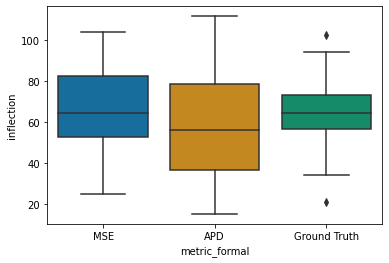

In [33]:
ax = sns.boxplot(y='inflection', x='metric_formal',data=all_groups[all_groups.metric_formal.isin(['MSE', 'APD', 'Ground Truth'])],
                order = ['MSE', 'APD', 'Ground Truth'])

In [40]:
model = smf.mixedlm("inflection ~ C(metric_formal, Treatment('Ground Truth')) ",
                    all_groups[all_groups.metric_formal.isin(['MSE', 'APD', 'Ground Truth'])],
                    groups= "group").fit()

model.summary()

/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Mixed Linear Model Regression Results
==============================================================================================
Model:                          MixedLM             Dependent Variable:             inflection
No. Observations:               245                 Method:                         REML      
No. Groups:                     4                   Scale:                          339.5914  
Min. group size:                23                  Log-Likelihood:                 -1055.0154
Max. group size:                96                  Converged:                      Yes       
Mean group size:                61.2                                                          
----------------------------------------------------------------------------------------------
                                                   Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
----------------------------------------------------------------------------------------------
Intercept                                          63.735    1.629 39.136 0.000  60.543 66.927
C(metric_formal, Treatment('Ground Truth'))[T.APD] -4.269    3.084 -1.384 0.166 -10.314  1.775
C(metric_formal, Treatment('Ground Truth'))[T.MSE]  2.424    2.733  0.887 0.375  -2.933  7.781
group Var                                           0.000                                     
==============================================================================================

"""

In [41]:
model = smf.mixedlm("inflection ~ C(metric_formal, Treatment('Ground Truth')) ",
                    all_groups[all_groups.metric_formal.isin(['MSE', 'APD', 'Ground Truth'])],
                    groups= "stim").fit()

model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Mixed Linear Model Regression Results
=============================================================================================
Model:                         MixedLM             Dependent Variable:             inflection
No. Observations:              245                 Method:                         REML      
No. Groups:                    24                  Scale:                          251.9951  
Min. group size:               8                   Log-Likelihood:                 -1036.4860
Max. group size:               11                  Converged:                      Yes       
Mean group size:               10.2                                                          
---------------------------------------------------------------------------------------------
                                                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------------------
Intercept                                          63.407    2.393 26.498 0.000 58.717 68.097
C(metric_formal, Treatment('Ground Truth'))[T.APD] -4.164    2.715 -1.534 0.125 -9.486  1.157
C(metric_formal, Treatment('Ground Truth'))[T.MSE]  2.598    2.367  1.098 0.272 -2.041  7.236
stim Var                                           89.506    2.226                           
=============================================================================================

"""

# Pre-train vs Fine-tune vs Ground Truth

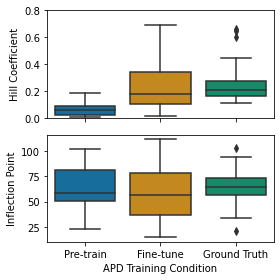

In [68]:
fig, ax = plt.subplots(2, 1, figsize=(4, 4), sharex=True)
for i, metric in enumerate(['slope', 'inflection']):
    sns.boxplot(y=metric, x='condition',data=all_groups[all_groups.condition.isin(['Pre-train', 'Fine-tune', 'Ground Truth'])],
                    order = ['Pre-train', 'Fine-tune', 'Ground Truth'], ax=ax[i])
    if metric=='slope':
        ax[i].set_ylim([0,0.8])
        ax[i].set_ylabel('Hill Coefficient')
    else:
        ax[i].set_ylabel('Inflection Point')
ax[0].set_xlabel('')
ax[1].set_xlabel('APD Training Condition')
plt.tight_layout()

In [42]:
model = smf.mixedlm("slope ~ C(condition, Treatment('Ground Truth')) ",
                    all_groups[all_groups.condition.isin(['Pre-train', 'Fine-tune', 'Ground Truth'])],
                    groups= "stim").fit()

model.summary()

/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retval

<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Mixed Linear Model Regression Results
===============================================================================================
Model:                          MixedLM               Dependent Variable:               slope  
No. Observations:               198                   Method:                           REML   
No. Groups:                     24                    Scale:                            0.0309 
Min. group size:                6                     Log-Likelihood:                   50.1904
Max. group size:                9                     Converged:                        No     
Mean group size:                8.2                                                            
-----------------------------------------------------------------------------------------------
                                                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------------
Intercept                                             0.238    0.019 12.602 0.000  0.201  0.275
C(condition, Treatment('Ground Truth'))[T.Fine-tune]  0.045    0.030  1.496 0.135 -0.014  0.104
C(condition, Treatment('Ground Truth'))[T.Pre-train] -0.173    0.040 -4.325 0.000 -0.251 -0.094
stim Var                                              0.003    0.016                           
===============================================================================================

"""

In [43]:
model = smf.mixedlm("slope ~ C(condition, Treatment('Ground Truth')) ",
                    all_groups[all_groups.condition.isin(['Pre-train', 'Fine-tune', 'Ground Truth'])],
                    groups= "group").fit()

model.summary()

/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Mixed Linear Model Regression Results
===============================================================================================
Model:                          MixedLM               Dependent Variable:               slope  
No. Observations:               198                   Method:                           REML   
No. Groups:                     4                     Scale:                            0.0330 
Min. group size:                23                    Log-Likelihood:                   49.9523
Max. group size:                80                    Converged:                        Yes    
Mean group size:                49.5                                                           
-----------------------------------------------------------------------------------------------
                                                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------------
Intercept                                             0.238    0.017 13.894 0.000  0.205  0.272
C(condition, Treatment('Ground Truth'))[T.Fine-tune]  0.045    0.031  1.437 0.151 -0.016  0.106
C(condition, Treatment('Ground Truth'))[T.Pre-train] -0.176    0.043 -4.141 0.000 -0.260 -0.093
group Var                                             0.000    0.004                           
===============================================================================================

"""

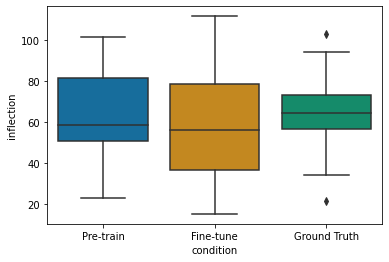

In [44]:
ax = sns.boxplot(y='inflection', x='condition',data=all_groups[all_groups.condition.isin(['Pre-train', 'Fine-tune', 'Ground Truth'])],
                order = ['Pre-train', 'Fine-tune', 'Ground Truth'])

In [69]:
model = smf.mixedlm("inflection ~ C(condition, Treatment('Ground Truth')) ",
                    all_groups,
                    groups= "group").fit()

model.summary()

/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Mixed Linear Model Regression Results
================================================================================================
Model:                          MixedLM              Dependent Variable:              inflection
No. Observations:               268                  Method:                          REML      
No. Groups:                     4                    Scale:                           350.8260  
Min. group size:                46                   Log-Likelihood:                  -1156.2012
Max. group size:                96                   Converged:                       Yes       
Mean group size:                67.0                                                            
------------------------------------------------------------------------------------------------
                                                     Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
------------------------------------------------------------------------------------------------
Intercept                                            63.735    1.655 38.504 0.000  60.491 66.980
C(condition, Treatment('Ground Truth'))[T.Fine-tune] -4.269    3.141 -1.359 0.174 -10.426  1.887
C(condition, Treatment('Ground Truth'))[T.MSE]        2.424    2.779  0.872 0.383  -3.022  7.870
C(condition, Treatment('Ground Truth'))[T.Pre-train] -0.435    3.872 -0.112 0.911  -8.024  7.155
group Var                                             0.000                                     
================================================================================================

"""

In [45]:
model = smf.mixedlm("inflection ~ C(condition, Treatment('Ground Truth')) ",
                    all_groups[all_groups.condition.isin(['Pre-train', 'Fine-tune', 'Ground Truth'])],
                    groups= "group").fit()

model.summary()

/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Mixed Linear Model Regression Results
================================================================================================
Model:                          MixedLM              Dependent Variable:              inflection
No. Observations:               198                  Method:                          REML      
No. Groups:                     4                    Scale:                           337.9633  
Min. group size:                23                   Log-Likelihood:                  -851.0917 
Max. group size:                80                   Converged:                       Yes       
Mean group size:                49.5                                                            
------------------------------------------------------------------------------------------------
                                                     Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
------------------------------------------------------------------------------------------------
Intercept                                            64.251    2.283 28.145 0.000  59.776 68.725
C(condition, Treatment('Ground Truth'))[T.Fine-tune] -4.760    3.182 -1.496 0.135 -10.997  1.477
C(condition, Treatment('Ground Truth'))[T.Pre-train] -0.950    5.162 -0.184 0.854 -11.066  9.167
group Var                                             6.737    0.726                            
================================================================================================

"""

In [46]:
model = smf.mixedlm("inflection ~ C(condition, Treatment('Ground Truth')) ",
                    all_groups[all_groups.condition.isin(['Pre-train', 'Fine-tune', 'Ground Truth'])],
                    groups= "stim").fit()

model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Mixed Linear Model Regression Results
================================================================================================
Model:                          MixedLM              Dependent Variable:              inflection
No. Observations:               198                  Method:                          REML      
No. Groups:                     24                   Scale:                           277.9219  
Min. group size:                6                    Log-Likelihood:                  -843.5888 
Max. group size:                9                    Converged:                       Yes       
Mean group size:                8.2                                                             
------------------------------------------------------------------------------------------------
                                                     Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
------------------------------------------------------------------------------------------------
Intercept                                            63.750    2.216 28.770 0.000  59.407 68.093
C(condition, Treatment('Ground Truth'))[T.Fine-tune] -4.447    2.852 -1.560 0.119 -10.036  1.142
C(condition, Treatment('Ground Truth'))[T.Pre-train] -0.123    3.783 -0.033 0.974  -7.539  7.292
stim Var                                             64.983    1.853                            
================================================================================================

"""

# normalize

In [47]:
def subtract_behav(group_behav, item):
    def _subtract_behav(x):
        try:
            return x[item]-group_behav[x['stim']][item]
        except:
            return np.NaN
    return _subtract_behav

In [48]:
all_groups.group.unique()

array(['Group 1', 'Group 2', 'Group 3', 'Pre-train'], dtype=object)

In [49]:
pretrain_df = all_groups[(all_groups.condition=='Pre-train')].reset_index(drop=True)
pretrain_df.head()

,min_val,max_val,slope,inflection,group,metric,subj,condition,metric_formal,stim
0,1.000000e-16,0.546898,0.020997,82.679161,Pre-train,fcosine,Pre-train,Pre-train,Pre-train,ae
1,2.792371e-02,1.000000,0.010351,61.352500,Pre-train,fcosine,Pre-train,Pre-train,Pre-train,af
2,6.195373e-02,1.000000,0.027773,49.199347,Pre-train,fcosine,Pre-train,Pre-train,Pre-train,ag
3,3.114233e-01,0.641320,0.074730,72.793759,Pre-train,fcosine,Pre-train,Pre-train,Pre-train,ah
4,2.859399e-01,1.000000,0.088148,95.212692,Pre-train,fcosine,Pre-train,Pre-train,Pre-train,be


In [115]:
import copy
normalized_df = pd.DataFrame()
for group in ['Group 1', 'Group 2', 'Group 3']:
    pretrain_df_group = copy.deepcopy(pretrain_df)
    group_df = all_groups[all_groups.group==group].reset_index(drop=True)
    group_behav = group_df[group_df.condition=='Ground Truth'][['stim', 'slope', 'inflection']].set_index('stim').T.to_dict('stim')
    group_df['d_slope'] = group_df.apply(lambda x: subtract_behav(group_behav, 'slope')(x), axis=1)
    group_df['d_inflection'] = group_df.apply(lambda x: subtract_behav(group_behav, 'inflection')(x), axis=1)
    pretrain_df_group['d_slope'] = pretrain_df_group.apply(lambda x: subtract_behav(group_behav, 'slope')(x), axis=1)
    pretrain_df_group['d_inflection'] = pretrain_df_group.apply(lambda x: subtract_behav(group_behav, 'inflection')(x), axis=1)
    normalized_df = pd.concat([normalized_df, group_df, pretrain_df_group]).reset_index(drop=True)

/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/pandas/core/frame.py:1554: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  FutureWarning,


In [116]:
normalized_df = normalized_df.dropna()

In [117]:
normalized_df

,min_val,max_val,slope,inflection,group,metric,condition,metric_formal,stim,d_slope,d_inflection
0,1.000000e-16,1.000000,0.033214,75.202742,Group 1,rmse,MSE,MSE,ae,-0.088473,23.820172
1,1.000000e-16,0.945304,0.032496,84.500302,Group 1,rmse,MSE,MSE,af,-0.082862,28.164192
2,1.000000e-16,0.860692,0.037051,76.503340,Group 1,rmse,MSE,MSE,ag,-0.081716,28.600583
3,1.000000e-16,0.616709,0.065078,56.980419,Group 1,rmse,MSE,MSE,ah,-0.071602,-11.165764
4,7.801580e-03,0.904488,0.054682,84.002627,Group 1,rmse,MSE,MSE,be,-0.113781,18.117609
...,...,...,...,...,...,...,...,...,...,...,...
206,3.783296e-02,0.859264,0.098685,52.841649,Pre-train,fcosine,Pre-train,Pre-train,bc,-0.090398,-16.651672
207,9.230453e-02,1.000000,0.065240,101.637249,Pre-train,fcosine,Pre-train,Pre-train,bd,-0.053688,20.611946
208,1.000000e-16,0.882292,0.056272,30.104017,Pre-train,fcosine,Pre-train,Pre-train,eh,-0.123695,-48.177152
209,4.780699e-02,1.000000,0.021472,56.000070,Pre-train,fcosine,Pre-train,Pre-train,fg,-0.559270,-22.445266


In [124]:
normalized_df = normalized_df.drop(normalized_df[normalized_df.metric_formal=='Ground Truth'].index).reset_index(drop=True)

In [125]:
normalized_df.groupby('metric_formal')[['d_slope', 'd_inflection']].median()

,d_slope,d_inflection
metric_formal,,
APD,0.010330,-2.792574
MSE,-0.137075,6.699365
Pre-train,-0.121730,0.204055


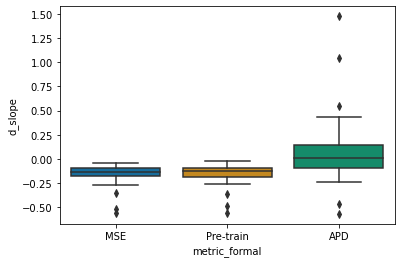

In [127]:
ax = sns.boxplot(x='metric_formal', y='d_slope', data=normalized_df,
                order = ['MSE', 'Pre-train','APD', ])

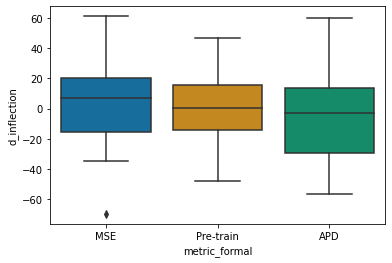

In [128]:
ax = sns.boxplot(x='metric_formal', y='d_inflection', data=normalized_df,
                order = ['MSE', 'Pre-train','APD', ])

In [131]:
model = smf.mixedlm("d_slope ~  C(metric_formal, Treatment('APD'))",
                    normalized_df,
                    groups= "stim").fit()

model.summary()

/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retval

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Mixed Linear Model Regression Results
==========================================================================================
Model:                         MixedLM             Dependent Variable:             d_slope
No. Observations:              140                 Method:                         REML   
No. Groups:                    24                  Scale:                          0.0417 
Min. group size:               4                   Log-Likelihood:                 15.0324
Max. group size:               6                   Converged:                      No     
Mean group size:               5.8                                                        
------------------------------------------------------------------------------------------
                                                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------
Intercept                                        0.076    0.031  2.443 0.015  0.015  0.136
C(metric_formal, Treatment('APD'))[T.MSE]       -0.232    0.042 -5.509 0.000 -0.315 -0.150
C(metric_formal, Treatment('APD'))[T.Pre-train] -0.222    0.042 -5.224 0.000 -0.305 -0.139
stim Var                                         0.002    0.013                           
==========================================================================================

"""

In [130]:
model = smf.mixedlm("d_inflection ~  C(metric_formal, Treatment('APD'))",
                    normalized_df,
                    groups= "stim").fit()

model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Mixed Linear Model Regression Results
============================================================================================
Model:                        MixedLM            Dependent Variable:            d_inflection
No. Observations:             140                Method:                        REML        
No. Groups:                   24                 Scale:                         404.1419    
Min. group size:              4                  Log-Likelihood:                -628.8542   
Max. group size:              6                  Converged:                     Yes         
Mean group size:              5.8                                                           
--------------------------------------------------------------------------------------------
                                                 Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------------------------------------
Intercept                                        -4.527    4.371 -1.036 0.300 -13.094  4.041
C(metric_formal, Treatment('APD'))[T.MSE]         8.199    4.147  1.977 0.048   0.071 16.327
C(metric_formal, Treatment('APD'))[T.Pre-train]   3.465    4.191  0.827 0.408  -4.750 11.679
stim Var                                        251.392    5.189                            
============================================================================================

"""